# Importing Essential Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Loading data:

In [24]:
images = np.load('/content/drive/MyDrive/DL/images.npy')
masks = np.load('/content/drive/MyDrive/DL/masks.npy')

print("Shape of Loaded images: ", images.shape)
print("Shape of Loaded Masks: ", masks.shape)

Shape of Loaded images:  (5088, 240, 240, 3)
Shape of Loaded Masks:  (5088, 240, 240)


In [25]:
masks[masks >0.5] = 1.0
masks[masks <= 0.5] = 0.0

##Visulaizing the image and it's mask

Image


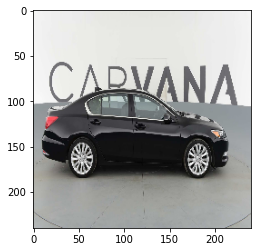

It's Mask


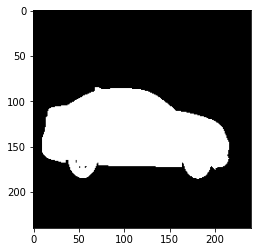

In [26]:
idx = 12
plt.figure(1)
print("Image")
plt.imshow(images[idx])
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[idx], cmap= 'gray')
plt.show()

Checking if GPU is available

In [27]:
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the images to the device

In [28]:
val = images[4900:5088]   #Validation images
val_mask = masks[4900:5088]

In [29]:
images = images[0:4900]   #Training images
masks = masks[0:4900]

In [30]:
images = torch.tensor(images, device = DEVICE, dtype = torch.float32)
masks = torch.tensor(masks, device = DEVICE)

val = torch.tensor(val, device = DEVICE, dtype = torch.float32)
val_mask = torch.tensor(val_mask, device = DEVICE)

In [31]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)
val = val.permute(0,3,1,2)

#Creating Unet architecture

In [42]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels): 
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)     

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    
    #Upsampling part
    out = self.up1(out)    
    out = torch.cat((out_4, out), dim = 1)
    out = self.conv6(out)

    out = self.up2(out)     
    out = torch.cat((out_3, out), dim = 1)
    out = self.conv7(out)

    out = self.up3(out)     
    out = torch.cat((out_2, out), dim = 1)
    out = self.conv8(out)

    out = self.up4(out)     
    out = torch.cat((out_1, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out


In [43]:
model = unet(3, 2).to(device = DEVICE)   #5 classes for each pixels

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
step_lr = lr_scheduler.StepLR(optimizer, step_size= 300, gamma = 0.75) 

## Some essential stuffs required for training

In [45]:
from torch.utils.data import Dataset, DataLoader 

class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch



In [46]:
data = CustomImageDataset(images, masks)

In [47]:
batchsize = 40
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [48]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2).to(DEVICE)

## Training the network (Model)

In [50]:
#Model Training
loss_graph = []
num_epochs = 20

num_train = images.shape[0]
gamma = 1.4  #Hyperparaeter

path_folder = '/content/drive/MyDrive/DL/saved_weights/unet'

for j in range(num_epochs):

  with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Jaccard index before epoch ", j, " is: ", jaccard(pred, val_mask).cpu().item()*100)

    #saving the weights of the model:
    PATH = os.path.join(path_folder, 'model_' + str(j+1)+ '.pth')
    torch.save(model.state_dict(), PATH)



  model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1).long()
  
    #Focal loss:
    out = torch.softmax(y_pred, axis = 1)  #to make probability
    idx = torch.arange(y_pred.shape[0])

    focal_loss = torch.sum( -1*((1 - out[idx,y_batch])**gamma )*torch.log( out[idx,y_batch]) ) /y_pred.shape[0]

    focal_loss.backward()
    optimizer.step()
    loss_graph.append(focal_loss.cpu().item())

  print("Epoch: ", j+1, ", loss is: ", focal_loss.cpu().item())
  #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])



Jaccard index before epoch  0  is:  12.080119550228119
Epoch:  1 , loss is:  0.00820007175207138
Jaccard index before epoch  1  is:  97.53454327583313
Epoch:  2 , loss is:  0.006801087409257889
Jaccard index before epoch  2  is:  98.31860065460205
Epoch:  3 , loss is:  0.0056893411092460155
Jaccard index before epoch  3  is:  98.55915307998657
Epoch:  4 , loss is:  0.003842611564323306
Jaccard index before epoch  4  is:  98.71713519096375
Epoch:  5 , loss is:  0.003941446077078581
Jaccard index before epoch  5  is:  98.81339073181152
Epoch:  6 , loss is:  0.0035399964544922113
Jaccard index before epoch  6  is:  98.93773198127747
Epoch:  7 , loss is:  0.0032890138681977987
Jaccard index before epoch  7  is:  98.89163374900818
Epoch:  8 , loss is:  0.002669078065082431
Jaccard index before epoch  8  is:  98.96959066390991
Epoch:  9 , loss is:  0.002465389668941498
Jaccard index before epoch  9  is:  99.02344942092896
Epoch:  10 , loss is:  0.0024393945932388306
Jaccard index before epoc

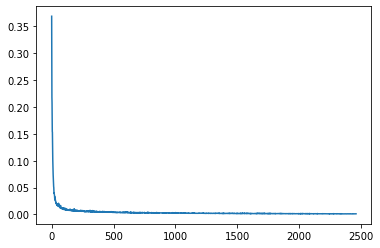

In [51]:
plt.plot(loss_graph)

## Prediction on train data


Image


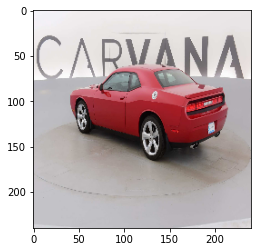


Actual mask


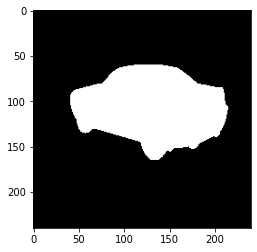

In [56]:
idx = 198

y = model(images[idx].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
plt.figure(2)
print("\nImage")
plt.imshow((images[idx]/255.0).permute(1,2,0).detach().cpu().numpy())
plt.show()

plt.figure(4)
print("\nActual mask")
plt.imshow(np.array(masks[idx].clone().cpu()), cmap= 'gray')
plt.show()

## Prediction on validation data (unseen data):


Image


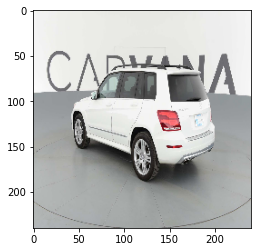


Actual mask


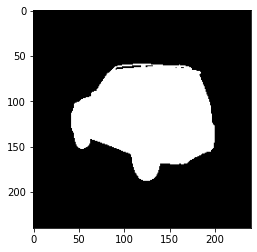

In [64]:
idx = 50

y = model(val[idx].reshape(1,val.shape[1], val.shape[2], val.shape[3]))
plt.figure(2)
print("\nImage")
plt.imshow((val[idx]/255).permute(1,2,0).detach().cpu().numpy())
plt.show()

plt.figure(4)
print("\nActual mask")
plt.imshow(np.array(val_mask[idx].clone().cpu()), cmap= 'gray')
plt.show()